In [1]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import os
import random

import git
import numpy as np
from gym import spaces

%matplotlib inline
from matplotlib import pyplot as plt

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

from PIL import Image

import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config

/opt/conda/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Neither `ifconfig` (`ifconfig -a`) nor `ip` (`ip address show`) commands are available, listing network interfaces is likely to fail


In [2]:
dir_path

'/data/reventh/habitat-lab'

In [3]:
config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-baselines/habitat_baselines/config/objectnav/hssd-200_ver_clip_hssd-hab.yaml"
            # "habitat-lab/habitat/config/benchmark/nav/objectnav/objectnav_hssd-hab.yaml",
        ),
        overrides=[
            # "habitat.environment.iterator_options.shuffle=False",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.height=512",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.width=512",
            # "habitat.simulator.create_renderer=False",
            "habitat.simulator.habitat_sim_v0.enable_hbao=True",
            "habitat_baselines.eval.video_option=[\"disk\"]",
            "habitat_baselines.rl.ddppo.pretrained_weights=data/ddppo-models/hssd_pretrained_best_on_hm3d_ckpt.pth",
            "habitat.simulator.habitat_sim_v0.allow_sliding=false",
        ],
        )

In [4]:
def display_sample(
    rgb_obs
):  # noqa: B006
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    return rgb_img

In [5]:
import json
from omegaconf import OmegaConf
print(json.dumps(OmegaConf.to_container(config), indent=4))

{
    "habitat_baselines": {
        "evaluate": false,
        "trainer_name": "ver",
        "updater_name": "PPO",
        "distrib_updater_name": "DDPPO",
        "torch_gpu_id": 0,
        "tensorboard_dir": "data/training/objectnav/hssd-hab/tb",
        "writer_type": "tb",
        "video_dir": "data/training/objectnav/hssd-hab/video_dir",
        "video_fps": 10,
        "test_episode_count": -1,
        "eval_ckpt_path_dir": "data/training/objectnav/hssd-hab/checkpoints/",
        "num_environments": 24,
        "num_processes": -1,
        "rollout_storage_name": "RolloutStorage",
        "checkpoint_folder": "data/training/objectnav/hssd-hab/checkpoints",
        "num_updates": 270000,
        "num_checkpoints": 500,
        "checkpoint_interval": -1,
        "total_num_steps": -1.0,
        "log_interval": 10,
        "log_file": "train.log",
        "force_blind_policy": false,
        "verbose": true,
        "vector_env_factory": {
            "_target_": "habitat_baselin

In [6]:
env = habitat.Env(config=config)

2024-05-09 06:29:59,044 Initializing dataset ObjectNav-v1
2024-05-09 06:30:13,340 initializing sim Sim-v0
2024-05-09 06:30:17,007 Initializing task ObjectNav-v1


In [7]:
obj = env.reset()

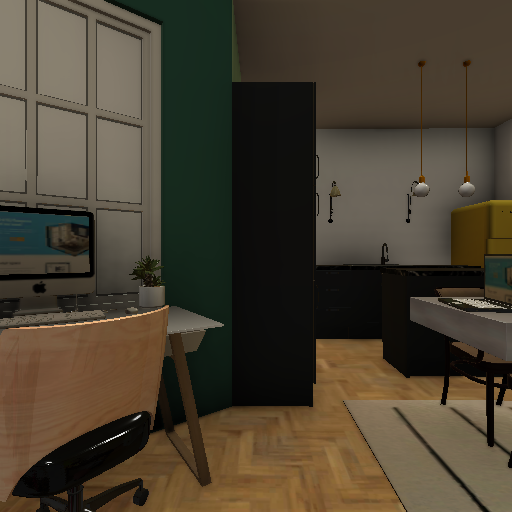

In [8]:
display_sample(obj["rgb"])

In [9]:
import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat.sims import make_sim
import magnum as mn

In [10]:
import json
from omegaconf import OmegaConf

# Assuming 'config' is your DictConfig object
dict_config = OmegaConf.to_container(config)

json_str = json.dumps(dict_config, indent=4)
print(json_str)

{
    "habitat_baselines": {
        "evaluate": false,
        "trainer_name": "ver",
        "updater_name": "PPO",
        "distrib_updater_name": "DDPPO",
        "torch_gpu_id": 0,
        "tensorboard_dir": "data/training/objectnav/hssd-hab/tb",
        "writer_type": "tb",
        "video_dir": "data/training/objectnav/hssd-hab/video_dir",
        "video_fps": 10,
        "test_episode_count": -1,
        "eval_ckpt_path_dir": "data/training/objectnav/hssd-hab/checkpoints/",
        "num_environments": 24,
        "num_processes": -1,
        "rollout_storage_name": "RolloutStorage",
        "checkpoint_folder": "data/training/objectnav/hssd-hab/checkpoints",
        "num_updates": 270000,
        "num_checkpoints": 500,
        "checkpoint_interval": -1,
        "total_num_steps": -1.0,
        "log_interval": 10,
        "log_file": "train.log",
        "force_blind_policy": false,
        "verbose": true,
        "vector_env_factory": {
            "_target_": "habitat_baselin

In [12]:
make_sim
sim = make_sim(id_sim=config.habitat.simulator.type, config=config.habitat.simulator)

2024-04-18 05:20:22,534 initializing sim Sim-v0
[05:20:23:956581]:[Warning]:[Sim] Simulator.cpp(533)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0


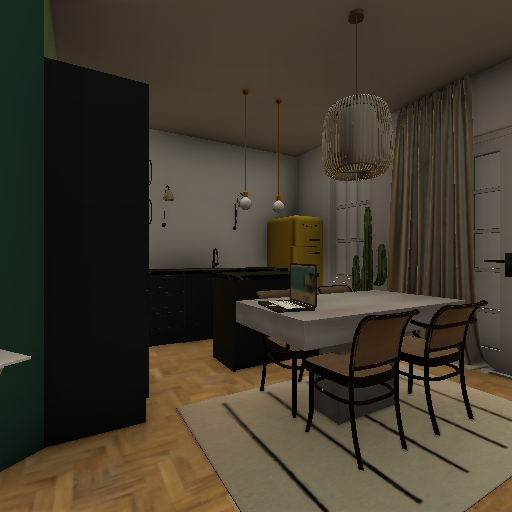

In [13]:
obj = env.step('turn_right')
display_sample(obj["rgb"])

In [28]:
from dataclasses import dataclass
import math

import habitat
from habitat.config.default_structured_configs import ActionConfig
from habitat.tasks.nav.nav import SimulatorTaskAction
from loguru import logger

# This is the configuration for our action.
@dataclass
class ParamaterizedActionConfig(ActionConfig):
    pos_cord = [0.0, 0.0, 0.0]
    angle_cord = [0.0, 0.0, 0.0, 0.0]

@habitat.registry.register_task_action
class ParamaterizedChangeLocation(SimulatorTaskAction):
    def __init__(self, *args, config, sim, **kwargs):
        super().__init__(*args, config=config, sim=sim, **kwargs)
        self.pos_cord = np.array([0.0, 0.0, 0.0])
        self.angle_cord = np.array([0.0, 0.0, 0.0, 0.0])

    # Change state of simulator by specified translation amountS
    def param_change_loc(self):
        self._sim.set_agent_state(
            self.pos_cord,
            self.angle_cord,
            reset_sensors=False,
        )
        
        
    def _get_uuid(self, *args, **kwargs) -> str:
        return "param_change_loc"

    # Step method for translation
    def step(self, pos_crd, angle_crd, **kwargs):
        self.pos_cord = pos_crd
        self.angle_cord = angle_crd
        self.param_change_loc()
    
with habitat.config.read_write(config):
    config.habitat.task.actions["param_chl"] = ParamaterizedActionConfig(type="ParamaterizedChangeLocation")
env = habitat.Env(config=config)

2024-04-18 05:31:12,927 Initializing dataset ObjectNav-v1


2024-04-18 05:31:27,051 initializing sim Sim-v0
[05:31:28:396602]:[Warning]:[Sim] Simulator.cpp(533)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
2024-04-18 05:31:29,362 Initializing task ObjectNav-v1


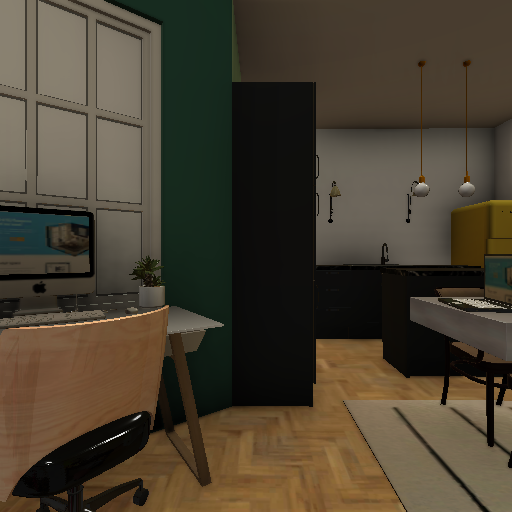

In [15]:
objt = env.reset()
obj = objt
display_sample(obj["rgb"])

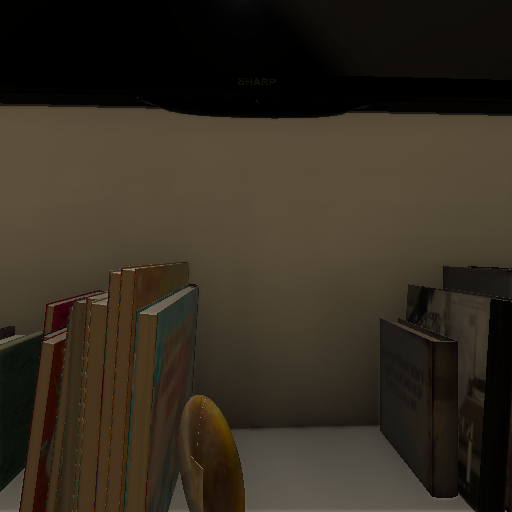

In [16]:
obj = env.step({"action":("param_chl"), "action_args":{'pos_crd':np.array([-13.67734, 0.13964, -5.43799]), 'angle_crd':np.array([0.0, -0.7224, 0.0, 0.69148])}})
display_sample(obj["rgb"])

In [17]:
def showstateat(pos, orientation):
    obj = env.step({"action":("param_chl"), "action_args":{'pos_crd':np.array(pos), 'angle_crd':np.array(orientation)}})
    return display_sample(obj["rgb"])

In [18]:
# How to use pretrained model for navigation 

In [19]:
# We have model architecture and corresponding weights
# Now initialize this model and generate data
#
# How to get data, sort this out tonight

In [20]:
import gzip
import json

with gzip.open('/data/reventh/habitat-lab/data/datasets/objectnav/hssd-hab/train/train.json.gz', 'rt') as f:
    data = json.load(f)

In [21]:
data

{'episodes': [],
 'category_to_task_category_id': {'chair': 0,
  'bed': 1,
  'potted_plant': 2,
  'toilet': 3,
  'tv': 4,
  'couch': 5},
 'category_to_scene_annotation_category_id': {'chair': 0,
  'bed': 1,
  'potted_plant': 2,
  'toilet': 3,
  'tv': 4,
  'couch': 5}}

In [22]:
with gzip.open('/data/reventh/habitat-lab/data/datasets/objectnav/hssd-hab/train/content/104348394_171513453.json.gz', 'rt') as f:
    data_tr = json.load(f)

In [23]:
data_tr.keys()

dict_keys(['goals_by_category', 'episodes', 'category_to_task_category_id', 'category_to_scene_annotation_category_id'])

In [24]:
data_tr['goals_by_category']['104348394_171513453_tv']

[{'position': [-13.08936, 1.75, -5.41226],
  'radius': None,
  'object_id': 33,
  'object_name': '8a643866e25ff2687ae34a7285e1927fed1205d3_:0000',
  'object_name_id': None,
  'object_category': 'tv',
  'room_id': None,
  'room_name': None,
  'view_points': [{'agent_state': {'position': [-13.67734, 0.13964, -5.43799],
     'rotation': [0.0, -0.7224, 0.0, 0.69148]},
    'iou': 0.63171},
   {'agent_state': {'position': [-13.67734, 0.13964, -5.34799],
     'rotation': [0.0, -0.66759, 0.0, 0.74453]},
    'iou': 0.62794},
   {'agent_state': {'position': [-13.67734, 0.13964, -5.52799],
     'rotation': [0.0, -0.77237, 0.0, 0.63517]},
    'iou': 0.61148},
   {'agent_state': {'position': [-13.76734, 0.13964, -5.43799],
     'rotation': [0.0, -0.72039, 0.0, 0.69357]},
    'iou': 0.60729},
   {'agent_state': {'position': [-13.76734, 0.13964, -5.34799],
     'rotation': [0.0, -0.67291, 0.0, 0.73972]},
    'iou': 0.6015},
   {'agent_state': {'position': [-13.67734, 0.13964, -5.25799],
     'rotatio

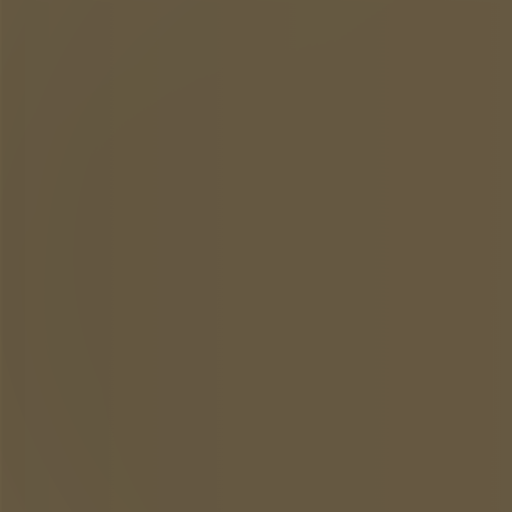

In [25]:
# Use short path heuristic and just apply point navigation
# Add object on a random point on the path
showstateat(pos=[-13.08936, 1.75, -5.41226], orientation=[0.0, -0.61083, 0.0, 0.79176])

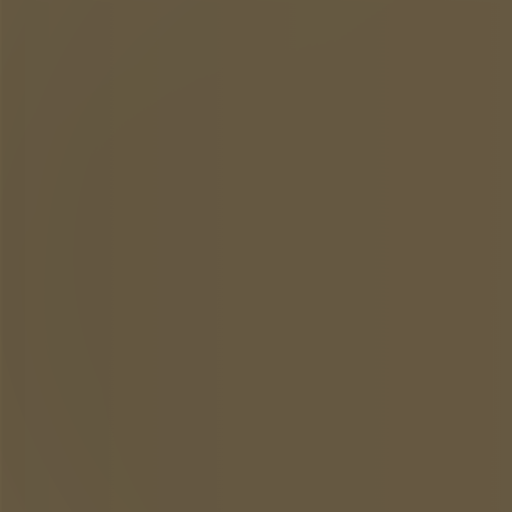

In [26]:
obj = env.step({"action": ('param_chl'), "action_args": {'pos_crd':[-13.08936, 1.75, -5.41226], 'angle_crd':[0.0, -0.61083, 0.0, 0.79176]}})
display_sample(obj["rgb"])

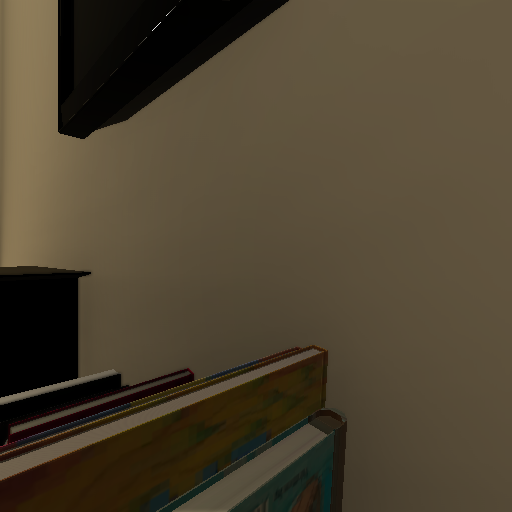

In [27]:
obj = env.step('turn_left')
display_sample(obj["rgb"])

In [28]:
# I guess the goals by category is essentially valid final positions for the agent
# And the episodes have agent's initial position and orientation

In [29]:
# Get what are the goals in your data?


In [30]:
sorted(data_tr['goals_by_category']['104348394_171513453_tv'][0]['view_points'], key=lambda x: x['iou'], reverse=True)

[{'agent_state': {'position': [-13.67734, 0.13964, -5.43799],
   'rotation': [0.0, -0.7224, 0.0, 0.69148]},
  'iou': 0.63171},
 {'agent_state': {'position': [-13.67734, 0.13964, -5.34799],
   'rotation': [0.0, -0.66759, 0.0, 0.74453]},
  'iou': 0.62794},
 {'agent_state': {'position': [-13.67734, 0.13964, -5.52799],
   'rotation': [0.0, -0.77237, 0.0, 0.63517]},
  'iou': 0.61148},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.43799],
   'rotation': [0.0, -0.72039, 0.0, 0.69357]},
  'iou': 0.60729},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.34799],
   'rotation': [0.0, -0.67291, 0.0, 0.73972]},
  'iou': 0.6015},
 {'agent_state': {'position': [-13.67734, 0.13964, -5.25799],
   'rotation': [0.0, -0.61083, 0.0, 0.79176]},
  'iou': 0.59563},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.52799],
   'rotation': [0.0, -0.76429, 0.0, 0.64488]},
  'iou': 0.59083},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.25799],
   'rotation': [0.0, -0.62375, 0.0, 0.78162]

In [31]:
sorted(data_tr['goals_by_category']['104348394_171513453_tv'][0]['view_points'], key=lambda x: (x['agent_state']['position'], x['agent_state']['rotation']))

[{'agent_state': {'position': [-14.03734, 0.13964, -5.79799],
   'rotation': [0.0, -0.82973, 0.0, 0.55817]},
  'iou': 0.42844},
 {'agent_state': {'position': [-14.03734, 0.13964, -5.70799],
   'rotation': [0.0, -0.80554, 0.0, 0.59254]},
  'iou': 0.44729},
 {'agent_state': {'position': [-14.03734, 0.13964, -5.61799],
   'rotation': [0.0, -0.77849, 0.0, 0.62766]},
  'iou': 0.46152},
 {'agent_state': {'position': [-14.03734, 0.13964, -5.52799],
   'rotation': [0.0, -0.74873, 0.0, 0.66288]},
  'iou': 0.47147},
 {'agent_state': {'position': [-14.03734, 0.13964, -5.43799],
   'rotation': [0.0, -0.71664, 0.0, 0.69745]},
  'iou': 0.47448},
 {'agent_state': {'position': [-14.03734, 0.13964, -5.34799],
   'rotation': [0.0, -0.68277, 0.0, 0.73063]},
  'iou': 0.47434},
 {'agent_state': {'position': [-14.03734, 0.13964, -5.25799],
   'rotation': [0.0, -0.64783, 0.0, 0.76178]},
  'iou': 0.46781},
 {'agent_state': {'position': [-14.03734, 0.13964, -5.16799],
   'rotation': [0.0, -0.61257, 0.0, 0.7904

In [32]:
[x for x in data_tr['episodes'] if (x['object_category']=='tv' and x['start_position']==[-14.03734, 0.13964, -5.79799] and x['start_rotation']==[0.0, -0.82973, 0.0, 0.55817])]

[]

In [33]:
sorted([x for x in data_tr['episodes'] if x['object_category']=='tv'], key=lambda x: (x['start_position'], x['start_rotation']))

[{'episode_id': '771',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-19.43811, 0.13964, -7.04298],
  'start_rotation': [0, 0.73894, 0, -0.67377],
  'info': {'geodesic_distance': 7.49635,
   'euclidean_distance': 6.63774,
   'closest_goal_object_id': 33},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'tv'},
 {'episode_id': '690',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-19.41502, 0.13964, -6.96088],
  'start_rotation': [0, 0.92659, 0, 0.37606],
  'info': {'geodesic_distance': 7.41314,
   'euclidean_distance': 6.5789,
   'closest_goal_object_id': 33},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'tv'},
 {'episode_id': '802',
 

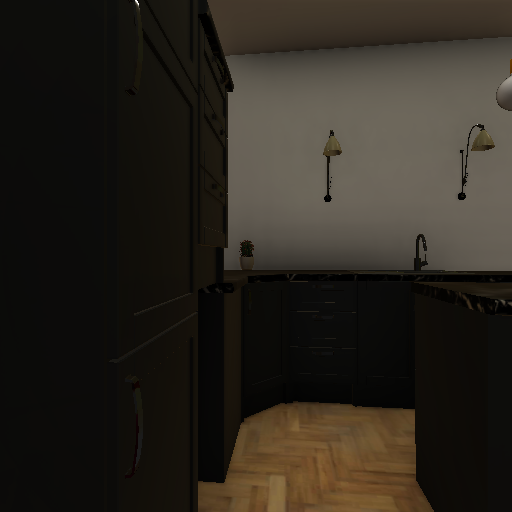

In [34]:
# See where test script saved your data
showstateat(pos=[-17.60428, 0.13964, -5.33424], orientation=[0, 0.74254, 0, 0.6698])

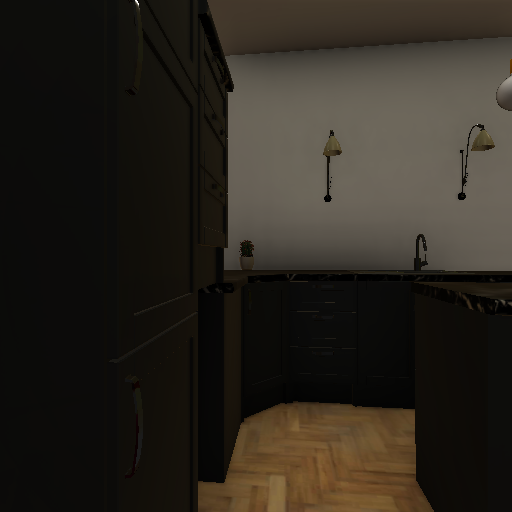

In [35]:
obj = env.step({"action": ('param_chl'), "action_args": {'pos_crd':[-17.60428, 0.13964, -5.33424], 'angle_crd':[0, 0.74254, 0, 0.6698]}})
display_sample(obj["rgb"])

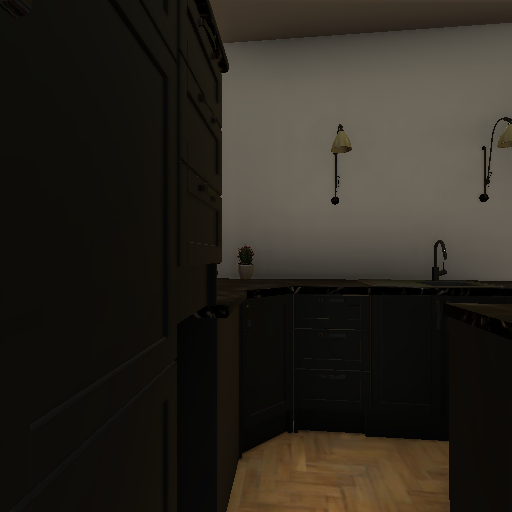

In [36]:
obj = env.step('move_forward')  
display_sample(obj["rgb"])

In [37]:
[x for x in data_tr['episodes'] if x['object_category']=='tv']

[{'episode_id': '664',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-17.60428, 0.13964, -5.33424],
  'start_rotation': [0, 0.74254, 0, 0.6698],
  'info': {'geodesic_distance': 4.48244,
   'euclidean_distance': 4.26263,
   'closest_goal_object_id': 33},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'tv'},
 {'episode_id': '665',
  'scene_id': '104348394_171513453',
  'scene_dataset_config': 'data/scene_datasets/hssd-hab/hssd-hab.scene_dataset_config.json',
  'additional_obj_config_paths': [],
  'start_position': [-16.49777, 0.13964, -6.79941],
  'start_rotation': [0, 0.61332, 0, -0.78983],
  'info': {'geodesic_distance': 5.01882,
   'euclidean_distance': 4.10255,
   'closest_goal_object_id': 33},
  'goals': [],
  'start_room': None,
  'shortest_paths': None,
  'object_category': 'tv'},
 {'episode_id': '666',
 

In [38]:
env.sim.get_agent_state().position, env.sim.get_agent_state().rotation

(array([-17.852957,   0.2     ,  -5.308557], dtype=float32),
 quaternion(0.669799983501434, 0, 0.742540001869202, 0))

In [39]:
sorted(data_tr['goals_by_category']['104348394_171513453_tv'][0]['view_points'], key=lambda x: x['iou'], reverse=True)

[{'agent_state': {'position': [-13.67734, 0.13964, -5.43799],
   'rotation': [0.0, -0.7224, 0.0, 0.69148]},
  'iou': 0.63171},
 {'agent_state': {'position': [-13.67734, 0.13964, -5.34799],
   'rotation': [0.0, -0.66759, 0.0, 0.74453]},
  'iou': 0.62794},
 {'agent_state': {'position': [-13.67734, 0.13964, -5.52799],
   'rotation': [0.0, -0.77237, 0.0, 0.63517]},
  'iou': 0.61148},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.43799],
   'rotation': [0.0, -0.72039, 0.0, 0.69357]},
  'iou': 0.60729},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.34799],
   'rotation': [0.0, -0.67291, 0.0, 0.73972]},
  'iou': 0.6015},
 {'agent_state': {'position': [-13.67734, 0.13964, -5.25799],
   'rotation': [0.0, -0.61083, 0.0, 0.79176]},
  'iou': 0.59563},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.52799],
   'rotation': [0.0, -0.76429, 0.0, 0.64488]},
  'iou': 0.59083},
 {'agent_state': {'position': [-13.76734, 0.13964, -5.25799],
   'rotation': [0.0, -0.62375, 0.0, 0.78162]

In [40]:
env.episodes[0].goals

[ObjectGoal(position=[-15.64935, 0.38545, -2.48578], radius=None, object_id=118, object_name='5f436be29314cec131bdedaea822e70dcb7a7891_:0000', object_name_id=None, object_category='toilet', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.21363], rotation=[0.0, 0.49726, 0.0, 0.8676]), iou=0.29581), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.12363], rotation=[0.0, 0.39045, 0.0, 0.92062]), iou=0.28302), ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.12363], rotation=[0.0, 0.43885, 0.0, 0.89856]), iou=0.26681), ObjectViewLocation(agent_state=AgentState(position=[-15.36479, 0.13964, -2.03363], rotation=[0.0, 0.27718, 0.0, 0.96082]), iou=0.26309), ObjectViewLocation(agent_state=AgentState(position=[-15.09479, 0.13964, -2.21363], rotation=[0.0, 0.52889, 0.0, 0.84869]), iou=0.26212), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.03363], 

In [7]:
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.config.default_structured_configs import (
    CollisionsMeasurementConfig,
    FogOfWarConfig,
    TopDownMapMeasurementConfig,
)
config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat-baselines/habitat_baselines/config/objectnav/hssd-200_ver_clip_hssd-hab.yaml"
            # "habitat-lab/habitat/config/benchmark/nav/objectnav/objectnav_hssd-hab.yaml",
        ),
        overrides=[
            # "habitat.environment.iterator_options.shuffle=False",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.height=512",
            "habitat.simulator.agents.main_agent.sim_sensors.rgb_sensor.width=512",
            # "habitat.simulator.create_renderer=False",
            "habitat.simulator.habitat_sim_v0.enable_hbao=True",
            "habitat_baselines.eval.video_option=[\"disk\"]",
            "habitat_baselines.rl.ddppo.pretrained_weights=data/ddppo-models/hssd_pretrained_best_on_hm3d_ckpt.pth",
            "habitat.simulator.habitat_sim_v0.allow_sliding=false"])

# with habitat.config.read_write(config):
#         config.habitat.task.measurements.update(
#             {
#                 "top_down_map": TopDownMapMeasurementConfig(
#                     map_padding=3,
#                     map_resolution=512,
#                     draw_source=True,
#                     draw_border=True,
#                     draw_shortest_path=True,
#                     draw_view_points=True,
#                     draw_goal_positions=True,
#                     draw_goal_aabbs=True,
#                     fog_of_war=FogOfWarConfig(
#                         draw=True,
#                         visibility_dist=5.0,
#                         fov=90,
#                     ),
#                 ),
#                 "collisions": CollisionsMeasurementConfig(),
#             }
#         )

In [8]:
from dataclasses import dataclass
import math

import habitat
from habitat.config.default_structured_configs import ActionConfig
from habitat.tasks.nav.nav import SimulatorTaskAction
from loguru import logger

# This is the configuration for our action.
@dataclass
class ParamaterizedActionConfig(ActionConfig):
    pos_cord = [0.0, 0.0, 0.0]
    angle_cord = [0.0, 0.0, 0.0, 0.0]

@habitat.registry.register_task_action
class ParamaterizedChangeLocation(SimulatorTaskAction):
    def __init__(self, *args, config, sim, **kwargs):
        super().__init__(*args, config=config, sim=sim, **kwargs)
        self.pos_cord = np.array([0.0, 0.0, 0.0])
        self.angle_cord = np.array([0.0, 0.0, 0.0, 0.0])

    # Change state of simulator by specified translation amountS
    def param_change_loc(self):
        self._sim.set_agent_state(
            self.pos_cord,
            self.angle_cord,
            reset_sensors=False,
        )
        
        
    def _get_uuid(self, *args, **kwargs) -> str:
        return "param_change_loc"

    # Step method for translation
    def step(self, pos_crd, angle_crd, **kwargs):
        self.pos_cord = pos_crd
        self.angle_cord = angle_crd
        self.param_change_loc()
    
with habitat.config.read_write(config):
    config.habitat.task.actions["param_chl"] = ParamaterizedActionConfig(type="ParamaterizedChangeLocation")
env = habitat.Env(config=config)

2024-04-18 05:34:24,619 Initializing dataset ObjectNav-v1
2024-04-18 05:34:37,816 initializing sim Sim-v0
[05:34:39:309210]:[Warning]:[Sim] Simulator.cpp(533)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
2024-04-18 05:34:40,261 Initializing task ObjectNav-v1


Renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.129.03
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


In [10]:
class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()
    


In [11]:
env = SimpleRLEnv(config=config)

2024-04-18 05:34:47,078 Initializing dataset ObjectNav-v1
2024-04-18 05:34:58,863 initializing sim Sim-v0
[05:35:00:307340]:[Warning]:[Sim] Simulator.cpp(533)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
2024-04-18 05:35:01,272 Initializing task ObjectNav-v1


In [12]:
env.config.task.measurements

{'distance_to_goal': {'type': 'DistanceToGoal', 'distance_to': 'VIEW_POINTS'}, 'success': {'type': 'Success', 'success_distance': 0.1}, 'spl': {'type': 'SPL'}, 'soft_spl': {'type': 'SoftSPL'}, 'distance_to_goal_reward': {'type': 'DistanceToGoalReward'}}

In [13]:
env.episodes[0].goals[0]

ObjectGoal(position=[-15.64935, 0.38545, -2.48578], radius=None, object_id=118, object_name='5f436be29314cec131bdedaea822e70dcb7a7891_:0000', object_name_id=None, object_category='toilet', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.21363], rotation=[0.0, 0.49726, 0.0, 0.8676]), iou=0.29581), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.12363], rotation=[0.0, 0.39045, 0.0, 0.92062]), iou=0.28302), ObjectViewLocation(agent_state=AgentState(position=[-15.18479, 0.13964, -2.12363], rotation=[0.0, 0.43885, 0.0, 0.89856]), iou=0.26681), ObjectViewLocation(agent_state=AgentState(position=[-15.36479, 0.13964, -2.03363], rotation=[0.0, 0.27718, 0.0, 0.96082]), iou=0.26309), ObjectViewLocation(agent_state=AgentState(position=[-15.09479, 0.13964, -2.21363], rotation=[0.0, 0.52889, 0.0, 0.84869]), iou=0.26212), ObjectViewLocation(agent_state=AgentState(position=[-15.27479, 0.13964, -2.03363], r

In [14]:
goal_radius = env.episodes[0].goals[0].radius
if goal_radius is None:
    goal_radius = config.habitat.simulator.forward_step_size
follower = ShortestPathFollower(
    env.habitat_env.sim, goal_radius, False
)
print(goal_radius)


0.25


In [15]:
follower = ShortestPathFollower(env.habitat_env.sim, goal_radius, False)

In [16]:
follower
follower.get_next_action(env.habitat_env.current_episode.goals[0].position)

2

In [17]:
from habitat.utils.visualizations import maps
from habitat.utils.visualizations.utils import images_to_video

def draw_top_down_map(info, output_size):
    return maps.colorize_draw_agent_and_fit_to_height(
        info["top_down_map"], output_size
    )

In [18]:
env.habitat_env.sim.get_agent_state().position

array([-14.97086  ,   0.2      ,  -5.8369913], dtype=float32)

In [19]:
# Use this for object navigation task
import shutil

path = None

for episode in range(3):
    env.reset()
    IMAGE_DIR = f'{os.getcwd()}/examples/tutorials'
    dirname = os.path.join(
        IMAGE_DIR, "shortest_path_example", "%02d" % episode
    )
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.makedirs(dirname)
    print("Agent stepping around inside environment.")
    images = []
    path = []
    while not env.habitat_env.episode_over:
        best_action = follower.get_next_action(
            env.habitat_env.current_episode.goals[0].view_points[0].agent_state.position

        )
        if best_action is None:
            break
        observations, reward, done, info = env.step(best_action)
        im = observations["rgb"]
        path.append(env.habitat_env.sim.get_agent_state().position)
        print(info)
        # top_down_map = draw_top_down_map(info, im.shape[0])
        # output_im = np.concatenate((im, top_down_map), axis=1)
        output_im = im
        images.append(output_im)
    images_to_video(images, dirname, "trajectory")
    print("Episode finished")

2024-04-18 05:35:16,213 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/00/trajectory.mp4


Agent stepping around inside environment.
{'distance_to_goal': 3.8532629013061523, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.00019437178013748113, 'distance_to_goal_reward': 0.0007491111755371094}
{'distance_to_goal': 3.8532629013061523, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.00019437178013748113, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.8532629013061523, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.00019437178013748113, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.8532629013061523, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.00019437178013748113, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.8532629013061523, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.00019437178013748113, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.6073403358459473, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.06400386813452208, 'distance_to_goal_reward': 0.24592256546020508}
{'distance_to_goal': 3.362459659576416, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.12754302563492825, 

100%|██████████| 37/37 [00:00<00:00, 115.22it/s]
2024-04-18 05:35:16,808 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/01/trajectory.mp4


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 3.1769633293151855, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0003264188209296526, 'distance_to_goal_reward': 0.0010373592376708984}
{'distance_to_goal': 3.1769633293151855, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0003264188209296526, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 3.1769633293151855, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.0003264188209296526, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 2.928239583969116, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.07859063891439, 'distance_to_goal_reward': 0.24872374534606934}
{'distance_to_goal': 2.680021286010742, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.15669581329413607, 'distance_to_goal_reward': 0.24821829795837402}
{'distance_to_goal': 2.4326813220977783, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.23452460823552213, 'distance_to_goal_reward': 0.24733996391296387}
{'distance_to_goal': 2.1870713233947754, 'success': 0.0, 'spl': 0.0,

100%|██████████| 34/34 [00:00<00:00, 265.07it/s]


Episode finished
Agent stepping around inside environment.
{'distance_to_goal': 8.218103408813477, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.028728529401587544, 'distance_to_goal_reward': 0.24307727813720703}
{'distance_to_goal': 7.976417541503906, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.05729261238852956, 'distance_to_goal_reward': 0.2416858673095703}
{'distance_to_goal': 7.735892295837402, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.08571952519958148, 'distance_to_goal_reward': 0.2405252456665039}
{'distance_to_goal': 7.735892295837402, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.08571952519958148, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 7.493464469909668, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.11437129791277034, 'distance_to_goal_reward': 0.24242782592773438}
{'distance_to_goal': 7.252264022827148, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.14287801062894157, 'distance_to_goal_reward': 0.24120044708251953}
{'distance_to_goal': 7.012608528137207, 'success': 0.0, 'spl': 

2024-04-18 05:35:17,348 Video created: /data/reventh/habitat-lab/examples/tutorials/shortest_path_example/02/trajectory.mp4


{'distance_to_goal': 1.2582721710205078, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8512888191879548, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.1105782985687256, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.868744287628614, 'distance_to_goal_reward': 0.14769387245178223}
{'distance_to_goal': 1.1105782985687256, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.868744287628614, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 1.1105782985687256, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.868744287628614, 'distance_to_goal_reward': -0.0}
{'distance_to_goal': 0.861196756362915, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.8982178979239739, 'distance_to_goal_reward': 0.24938154220581055}
{'distance_to_goal': 0.6123197078704834, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9276318837139552, 'distance_to_goal_reward': 0.24887704849243164}
{'distance_to_goal': 0.3649808168411255, 'success': 0.0, 'spl': 0.0, 'soft_spl': 0.9516908052377899, 'distance_to_goal_reward': 0.2473388910293579}
{'dista

100%|██████████| 68/68 [00:00<00:00, 286.45it/s]


Episode finished


In [20]:
IMAGE_DIR

'/data/reventh/habitat-lab/examples/tutorials'

In [21]:
def draw_top_down_map(info, output_size):
    return maps.colorize_draw_agent_and_fit_to_height(
        info["top_down_map"], output_size
    )

In [22]:

from habitat.utils.visualizations import maps

top_down_map = maps.get_topdown_map_from_sim(env.habitat_env.sim, map_resolution=512)

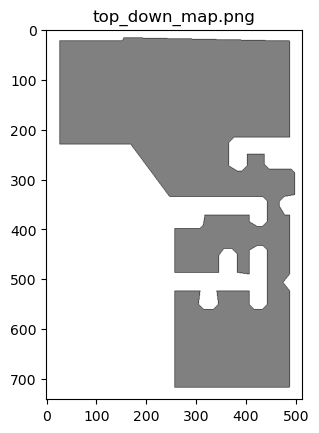

In [23]:
recolor_map = np.array(
            [[255, 255, 255], [128, 128, 128], [0, 0, 0]], dtype=np.uint8
        )
        # By default, `get_topdown_map_from_sim` returns image
        # containing 0 if occupied, 1 if unoccupied, and 2 if border
        # The line below recolors returned image so that
        # occupied regions are colored in [255, 255, 255],
        # unoccupied in [128, 128, 128] and border is [0, 0, 0]
top_down_map = recolor_map[top_down_map]
plt.imshow(top_down_map)
plt.title("top_down_map.png")
plt.show()


In [24]:
reformatted_path = [maps.to_grid(x[2], x[0], (top_down_map.shape[0], top_down_map.shape[1]), env.habitat_env.sim) for x in path]

In [25]:
top_down_map.shape

(741, 512, 3)

In [26]:
sim = env.habitat_env.sim
sim.pathfinder.get_bounds()

(array([-20.47359  ,   0.       ,  -8.0972395], dtype=float32),
 array([-12.897459 ,   2.8      ,   2.8678925], dtype=float32))

In [27]:
maps.draw_path(top_down_map, reformatted_path, color=10, thickness=2)

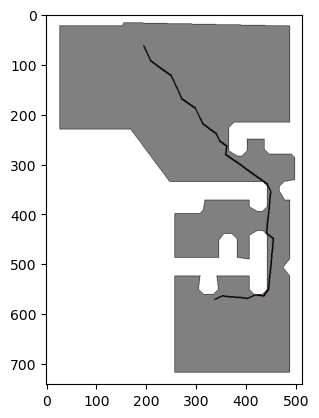

In [28]:
plt.imshow(top_down_map)

In [29]:

env.habitat_env.current_episode.goals[0]

ObjectGoal(position=[-15.26633, 0.52006, 1.64165], radius=None, object_id=43, object_name='97bdca87a1f24c2bee3bd7f57024f4dcb5827a37_:0000', object_name_id=None, object_category='bed', room_id=None, room_name=None, view_points=[ObjectViewLocation(agent_state=AgentState(position=[-15.61495, 0.13964, 0.37912], rotation=[0.0, -0.99094, 0.0, 0.1343]), iou=1.10401), ObjectViewLocation(agent_state=AgentState(position=[-15.52495, 0.13964, 0.37912], rotation=[0.0, -0.9949, 0.0, 0.10085]), iou=1.10309), ObjectViewLocation(agent_state=AgentState(position=[-15.70496, 0.13964, 0.37912], rotation=[0.0, -0.98606, 0.0, 0.16641]), iou=1.09667), ObjectViewLocation(agent_state=AgentState(position=[-15.43495, 0.13964, 0.37912], rotation=[0.0, -0.9978, 0.0, 0.06634]), iou=1.09336), ObjectViewLocation(agent_state=AgentState(position=[-15.34496, 0.13964, 0.37912], rotation=[0.0, -0.99952, 0.0, 0.03109]), iou=1.08281), ObjectViewLocation(agent_state=AgentState(position=[-14.08496, 0.13964, 1.54912], rotation=

In [30]:
#Can choose to add viewpoint instead of object location
# Done, chosen viewpoints highest iou viewpoint as navgoal

In [31]:
# Now, lets add counter example
# We have path, chose a random point on it and an obstacle, eg a square cube there and rerun the greedy algorithm
# Lets see after 30min break

In [32]:
path

[array([-17.586096,   0.2     ,  -7.16418 ], dtype=float32),
 array([-17.482342 ,   0.2      ,  -6.9367294], dtype=float32),
 array([-17.378588,   0.2     ,  -6.709279], dtype=float32),
 array([-17.378588,   0.2     ,  -6.709279], dtype=float32),
 array([-17.175007 ,   0.2      ,  -6.5641756], dtype=float32),
 array([-16.971426,   0.2     ,  -6.419072], dtype=float32),
 array([-16.767845 ,   0.2      ,  -6.2739687], dtype=float32),
 array([-16.767845 ,   0.2      ,  -6.2739687], dtype=float32),
 array([-16.664091,   0.2     ,  -6.046515], dtype=float32),
 array([-16.560337 ,   0.2      ,  -5.8190613], dtype=float32),
 array([-16.456583 ,   0.2      ,  -5.5916076], dtype=float32),
 array([-16.456583 ,   0.2      ,  -5.5916076], dtype=float32),
 array([-16.253002,   0.2     ,  -5.446504], dtype=float32),
 array([-16.049421 ,   0.2      ,  -5.3014007], dtype=float32),
 array([-16.049421 ,   0.2      ,  -5.3014007], dtype=float32),
 array([-15.945667,   0.2     ,  -5.073947], dtype=float32

In [33]:
env.habitat_env.sim

HabitatSim(config=Configuration(sim_cfg=<habitat_sim._ext.habitat_sim_bindings.SimulatorConfiguration object at 0x7f9bb84335f0>, agents=[AgentConfiguration(height=0.88, radius=0.18, sensor_specifications=[<habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f9e42e871d0>, <habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f9c1e13f770>], action_space={0: ActionSpec(name='stop', actuation=None), 1: ActionSpec(name='move_forward', actuation=ActuationSpec(amount=0.25, constraint=None)), 2: ActionSpec(name='turn_left', actuation=ActuationSpec(amount=30, constraint=None)), 3: ActionSpec(name='turn_right', actuation=ActuationSpec(amount=30, constraint=None))}, body_type='cylinder')], metadata_mediator=None, enable_batch_renderer=False), agents=[Agent(agent_config=AgentConfiguration(height=0.88, radius=0.18, sensor_specifications=[<habitat_sim._ext.habitat_sim_bindings.CameraSensorSpec object at 0x7f9e42e871d0>, <habitat_sim._ext.habitat_sim_bindings.CameraSens

In [35]:
env.reset()
obs = env.step({"action":("param_chl"), "action_args":{'pos_cord':[-15.480526, 0.2, 0.3613354]}})

TypeError: step() missing 2 required positional arguments: 'pos_crd' and 'angle_crd'